<a href="https://colab.research.google.com/github/Najmehmoazzen/Forecasting-of-Phase-Evolution/blob/main/Forecasting%2Bplot_window.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting of Phase Evolution

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Libraries

In [ ]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint        # for saving models
from tensorflow.keras.losses import MeanSquaredError          # loss function
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

### Initial values

In [ ]:
# Coupling value of Kuramoto model network
coupling=17
# List of window sizes to be used for training
window_sizes = [2,5,10,20,30]
# Number of epochs for training
n_epochs=15

### Read data file

In [ ]:
# Define the path to the CSV file in Google Drive
my_csv = Path(f"/content/drive/My Drive/Colab Notebooks/Forecasting phases project/Data/J={coupling}.csv")

# Read the CSV file
df = pd.read_csv(my_csv.resolve(), sep=',')

In [ ]:
# Select the first theta column and initialize phase_df with it
phase_df = df[f'theta{1}']

# Loop through the rest of the theta columns
for i in range(1, len(df.columns)):
    # Concatenate each subsequent theta column to phase_df along the columns axis
    phase_df = pd.concat([df[f'theta{i+1}'], phase_df], axis=1)

phase_df.head()

,theta60,theta59,theta58,theta57,theta56,theta55,theta54,theta53,theta52,theta51,...,theta10,theta9,theta8,theta7,theta6,theta5,theta4,theta3,theta2,theta1
0,1.69843,-2.89774,-0.378518,-0.153740,2.11712,0.581160,0.905752,0.094570,0.975552,1.86235,...,-2.83269,-3.02805,-0.645692,0.065196,-3.00068,1.26717,0.968401,-0.795694,2.72986,-1.04879
1,1.68656,-2.87724,-0.368111,-0.128015,2.08074,0.606465,0.888090,0.142258,0.942676,1.85352,...,-2.84575,-3.02455,-0.645261,0.058165,-2.97929,1.25316,0.994780,-0.802275,2.72641,-1.07543
2,1.67463,-2.85666,-0.357716,-0.102362,2.04460,0.631824,0.870455,0.190134,0.910010,1.84452,...,-2.85862,-3.02092,-0.644861,0.051097,-2.95797,1.23900,1.020940,-0.808960,2.72293,-1.10234
3,1.66265,-2.83598,-0.347336,-0.076799,2.00870,0.657228,0.852842,0.238154,0.877558,1.83534,...,-2.87130,-3.01716,-0.644499,0.043985,-2.93669,1.22470,1.046880,-0.815751,2.71943,-1.12952
4,1.65062,-2.81518,-0.336972,-0.051346,1.97305,0.682663,0.835246,0.286274,0.845323,1.82599,...,-2.88378,-3.01329,-0.644186,0.036822,-2.91545,1.21025,1.072590,-0.822653,2.71591,-1.15699


In [ ]:
#reverse  theta60 to theta1
phase_df=phase_df[phase_df.columns[::-1]]
phase_df

,theta1,theta2,theta3,theta4,theta5,theta6,theta7,theta8,theta9,theta10,...,theta51,theta52,theta53,theta54,theta55,theta56,theta57,theta58,theta59,theta60
0,-1.04879,2.72986,-0.795694,0.968401,1.26717,-3.00068,0.065196,-0.645692,-3.02805,-2.83269,...,1.862350,0.975552,0.094570,0.905752,0.581160,2.117120,-0.153740,-0.378518,-2.897740,1.698430
1,-1.07543,2.72641,-0.802275,0.994780,1.25316,-2.97929,0.058165,-0.645261,-3.02455,-2.84575,...,1.853520,0.942676,0.142258,0.888090,0.606465,2.080740,-0.128015,-0.368111,-2.877240,1.686560
2,-1.10234,2.72293,-0.808960,1.020940,1.23900,-2.95797,0.051097,-0.644861,-3.02092,-2.85862,...,1.844520,0.910010,0.190134,0.870455,0.631824,2.044600,-0.102362,-0.357716,-2.856660,1.674630
3,-1.12952,2.71943,-0.815751,1.046880,1.22470,-2.93669,0.043985,-0.644499,-3.01716,-2.87130,...,1.835340,0.877558,0.238154,0.852842,0.657228,2.008700,-0.076799,-0.347336,-2.835980,1.662650
4,-1.15699,2.71591,-0.822653,1.072590,1.21025,-2.91545,0.036822,-0.644186,-3.01329,-2.88378,...,1.825990,0.845323,0.286274,0.835246,0.682663,1.973050,-0.051346,-0.336972,-2.815180,1.650620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39997,-1.50626,-2.67366,0.952892,-1.465940,-1.95349,-1.40668,2.576650,2.063790,-1.92482,-1.19502,...,-0.265686,-0.752206,1.070890,-0.630835,1.835120,0.193358,-0.544874,-2.350910,-0.760136,-0.530679
39998,-1.53006,-2.66587,0.926758,-1.445340,-1.95777,-1.36828,2.563770,2.043840,-1.91026,-1.19059,...,-0.274327,-0.774431,1.096290,-0.652989,1.847410,0.164931,-0.526347,-2.343240,-0.738687,-0.544792
39999,-1.55360,-2.65824,0.900371,-1.424620,-1.96201,-1.32989,2.550860,2.024050,-1.89551,-1.18630,...,-0.283079,-0.796375,1.121630,-0.674773,1.859490,0.136470,-0.508117,-2.335550,-0.717667,-0.558970
40000,-1.57687,-2.65077,0.873742,-1.403790,-1.96621,-1.29153,2.537910,2.004410,-1.88060,-1.18214,...,-0.291945,-0.818049,1.146930,-0.696189,1.871340,0.107977,-0.490189,-2.327840,-0.697061,-0.573205


### Create inputs and labels

In [ ]:
def df_to_X_y(df, window_size):
  # Converts the DataFrame to an array
  df_as_np = df.to_numpy()
  # Initialize empty lists to hold the input sequences (X) and corresponding labels (y)
  X = []
  y = []
  # Iterate over the DataFrame to create sequences of a given window size
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]            # Extract a sequence of 'window_size' rows starting from index i.
    X.append(row)                                           # Add the extracted sequence to the X list.
    label =[]                                               # Initialize a list to hold the labels
    label.append(df_as_np[i+window_size][0])                # Append the label (target) for the sequence, which is the first column value at the end of the window

    # Loop through the remaining columns of the row immediately following the sequence.
    for j in range (1,len(df.columns)):
        label.append(df_as_np[i+window_size][j])            # Append the remaining values of the row at the end of the window to the label

    y.append(label)
  return np.array(X), np.array(y)                           # Convert the lists X and y to arrays and return them.

### Split train and test data and create the model

In [ ]:
def create_and_train_model(window_size, epochs):
    # Make inputs and actual labels of them
    X, y = df_to_X_y(phase_df, window_size)

    # Split train and test data
    X_train, y_train = X[5000:25000], y[5000:25000]
    X_val, y_val = X[25000:30000], y[25000:30000]
    X_test, y_test = X[30000:], y[30000:]
    print(X_train.shape)
    print(y_train.shape)
    print(X_val.shape)
    print(y_val.shape)
    print(X_test.shape)
    print(y_test.shape)

    # Make model
    model = Sequential()
    model.add(InputLayer((window_size, 60)))
    model.add(LSTM(128))
    model.add(Dense(6400, 'relu'))
    model.add(Dense(60, 'linear'))
    model.summary()

    # Compile the model
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs)

    # Saving model
    model_filename = f'/content/drive/My Drive/Colab Notebooks/Forecasting phases project/Results/models/model_LSTM_hidden6400_J={coupling}_window{window_size}.keras'
    model.save(model_filename)

    # Make predictions
    predictions = model.predict(X_test)
    print(predictions)

    # Save actual and predicted values to text files
    np.savetxt(f"/content/drive/My Drive/Colab Notebooks/Forecasting phases project/Results/J={coupling}_window{window_size}_actual.txt", y_test, fmt='%.6e', delimiter='\t', newline='\n', encoding=None)
    np.savetxt(f"/content/drive/My Drive/Colab Notebooks/Forecasting phases project/Results/J={coupling}_window{window_size}_predicted.txt", predictions, fmt='%.6e', delimiter='\t', newline='\n', encoding=None)

    return history, predictions


### Training models with different window sizes

In [ ]:
# Dictionary to store training histories for each window size
histories = {}

# Loop over each window size in the list
for window_size in window_sizes:
    print(f"Training model with window size: {window_size}")
    history,_ = create_and_train_model(window_size, n_epochs)   # Create and train the model with the current window size
    histories[window_size] = history                            # Store the training history in the 'histories' dictionary with the window size

Training model with window size: 2
(20000, 2, 60)
(20000, 60)
(5000, 2, 60)
(5000, 60)
(10000, 2, 60)
(10000, 60)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 128)               96768     
                                                                 
 dense_12 (Dense)            (None, 6400)              825600    
                                                                 
 dense_13 (Dense)            (None, 60)                384060    
                                                                 
Total params: 1306428 (4.98 MB)
Trainable params: 1306428 (4.98 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
625/625 [==============================] - 18s 26ms/step - loss: 1.2433 - root_mean_squared_error: 1.1150 - val_loss: 0.7589 - val_root_mean_squared_error:

### Training loss vs epochs plot

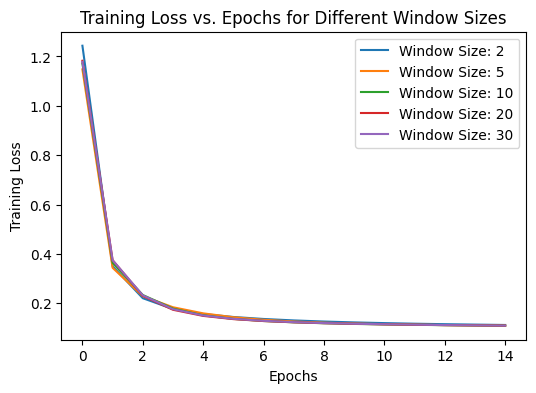

In [ ]:
plt.figure(figsize=(6, 4))

for window_size, history in histories.items():
    plt.plot(history.history['loss'], label=f'Window Size: {window_size}')

plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Epochs for Different Window Sizes')
plt.legend()
plt.savefig(f'/content/drive/My Drive/Colab Notebooks/Forecasting phases project/Results/training_loss_vs_epochs_J={coupling}.png')
plt.show()

### Plot results

In [ ]:
def plot_results(window_size):


    # Define the colors for the custom cyclic colormap
    colors = [
        (1.0, 0.0, 1.0),  # Magenta (255, 0, 255)
        (1.0, 0.0, 0.0),  # Red (255, 0, 0)
        (1.0, 1.0, 0.0),  # Yellow (255, 255, 0)
        (0.0, 1.0, 0.0),  # Green (0, 255, 0)
        (0.0, 1.0, 1.0),  # Cyan (0, 255, 255)
        (0.0, 0.0, 1.0),  # Blue (0, 0, 255)
        (1.0, 0.0, 1.0)   # Magenta (255, 0, 255)
    ]

    # Create the custom cyclic colormap
    custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

    fig = plt.figure()

    # _________________________________________________________
    ax_1 = plt.subplot(3, 4, (1, 4))
    # Read the input data
    with open(f"/content/drive/My Drive/Colab Notebooks/Forecasting phases project/Results/J={coupling}_window{window_size}_actual.txt") as textFile:  # ./Results/J={coupling}_actual.txt
        lines = [line.split() for line in textFile]

    lines = np.array(lines, dtype=float).transpose()  # Convert to numpy array and transpose
    print(np.min(lines))
    print(np.max(lines))
    # plot
    vmin = -np.pi
    vmax = np.pi
    plt.imshow(lines, cmap=custom_cmap, aspect='auto', interpolation='nearest', vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(ticks=[vmin, 0, vmax])
    cbar.ax.set_yticklabels(['-π', '0', 'π'])

    plt.title(f'LSTM (window {window_size})', fontsize=10)

    # plot
    # Customize tick parameters
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labeltop=False, labelsize=10,
                    labelcolor='#262626')
    plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelright=False, labelsize=10,
                    labelcolor='#262626')
    # Reverse the y-axis direction
    plt.gca().set_ylim(plt.gca().get_ylim()[::-1])
    # Set x and y limits
    plt.xlim(0, len(lines[0]))
    plt.ylim(0, 60)
    # Set labels
    plt.ylabel('Node (i)', fontsize=10, labelpad=10)
    plt.xlabel('Time (s)', fontsize=10)
    # _________________________________________________________

    ax_2 = plt.subplot(3, 4, (5, 8))

    # Read the input data
    with open(f"/content/drive/My Drive/Colab Notebooks/Forecasting phases project/Results/J={coupling}_window{window_size}_predicted.txt") as textFile:
        lines2 = [line.split() for line in textFile]
    lines2 = np.array(lines2, dtype=float).transpose()  # Convert to numpy array and transpose

    # Subtract 2*pi from values greater than pi
    lines2 = np.where(lines2 > np.pi, lines2 - 2 * np.pi, lines2)

    # Add 2*pi to values less than -pi
    lines2 = np.where(lines2 < -np.pi, lines2 + 2 * np.pi, lines2)

    print(np.min(lines2))
    print(np.max(lines2))
    # plot
    vmin = -np.pi
    vmax = np.pi
    plt.imshow(lines2, cmap=custom_cmap, aspect='auto', interpolation='nearest', vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(ticks=[vmin, 0, vmax])
    cbar.ax.set_yticklabels(['-π', '0', 'π'])

    # plot
    # Customize tick parameters
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labeltop=False, labelsize=10,
                    labelcolor='#262626')
    plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelright=False, labelsize=10,
                    labelcolor='#262626')
    # Reverse the y-axis direction
    plt.gca().set_ylim(plt.gca().get_ylim()[::-1])
    # Set x and y limits
    plt.xlim(0, len(lines2[0]))
    plt.ylim(0, 60)
    # Set labels
    plt.ylabel('Node (i)', fontsize=10, labelpad=10)
    plt.xlabel('Time (s)', fontsize=10)
    # _________________________________________________________


    s = (len(lines[:, 0]),len(lines[0, :]))
    lines3 = np.zeros(s)
    ax_3 = plt.subplot(3, 4, (9, 12))
    for i in range(len(lines[:, 0])):
        for j in range(len(lines[0, :])):
            lines3[i][j] = np.cos(lines2[i][j] - lines[i][j])

    print(np.min(lines3))
    print(np.max(lines3))
    # plot
    plt.imshow(lines3, cmap='RdPu', aspect='auto', interpolation='nearest')
    cbar = plt.colorbar(ticks=[-1.001, 0, 1])
    # cbar.ax.set_yticklabels(['-1', '0', '1'])
    # Customize tick parameters
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labeltop=False, labelsize=10,
                    labelcolor='#262626')
    plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelright=False, labelsize=10,
                    labelcolor='#262626')
    # Reverse the y-axis direction
    plt.gca().set_ylim(plt.gca().get_ylim()[::-1])
    # Set x and y limits
    plt.xlim(0, len(lines3[0]))
    print(len(lines3[0]))
    plt.ylim(0, 60)
    # Set labels
    plt.ylabel('Node (i)', fontsize=10, labelpad=10)
    plt.xlabel('Time (s)', fontsize=10)
    # Save the figure as a .png file
    plt.subplots_adjust(top=0.97, bottom=0.08, hspace=0.3, wspace=0.44)


    plt.gcf().set_size_inches(12, 3)
    #plt.savefig(f'/content/drive/My Drive/Colab Notebooks/Forecasting phases project/Results/result_J={coupling}_window{window_size}.pdf')
    plt.savefig(f'/content/drive/My Drive/Colab Notebooks/Forecasting phases project/Results/result_J={coupling}_window{window_size}.png' , dpi=300)


-3.14159
3.14158
-3.141481
3.141565
-0.9982794828524892
0.9999999999966718
10000
-3.14159
3.14158
-3.141591
3.141571
-0.995945348504403
0.9999999999997613
9997
-3.14159
3.14158
-3.141561
3.1415793071795863
-0.8986971671018863
0.9999999999995
9992
-3.14159
3.14158
-3.141587307179586
3.141537
-0.7648851847987537
0.99999999999992
9982
-3.14159
3.14158
-3.14157
3.1415793071795863
-0.933829549088466
0.999999999992
9972


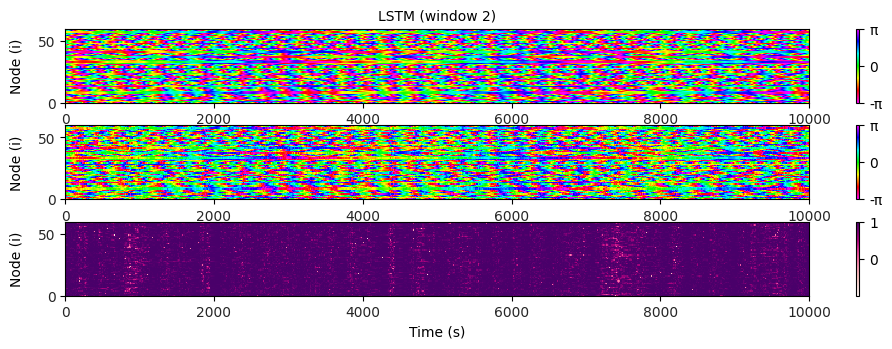

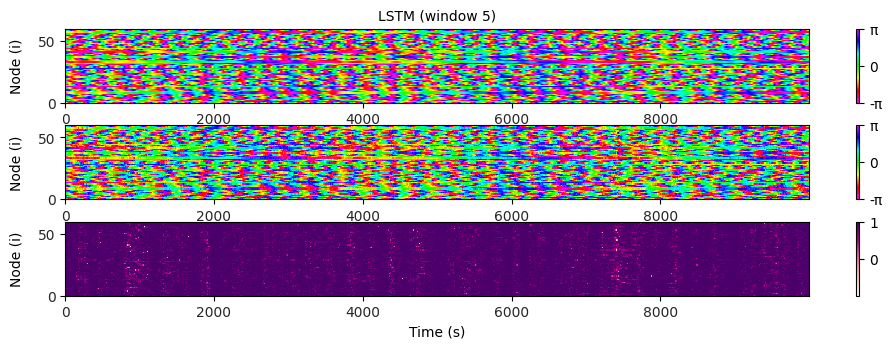

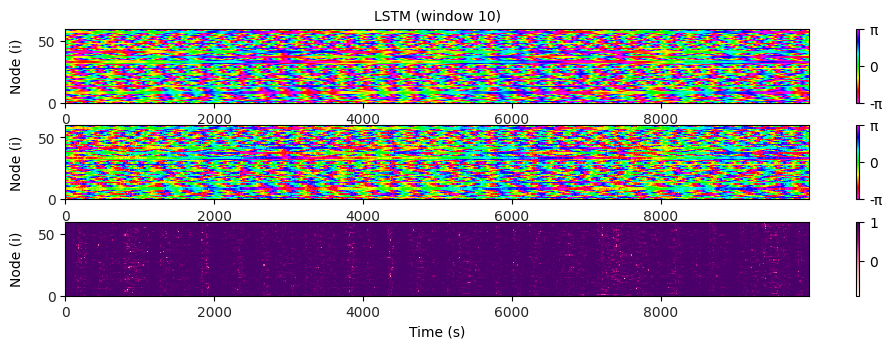

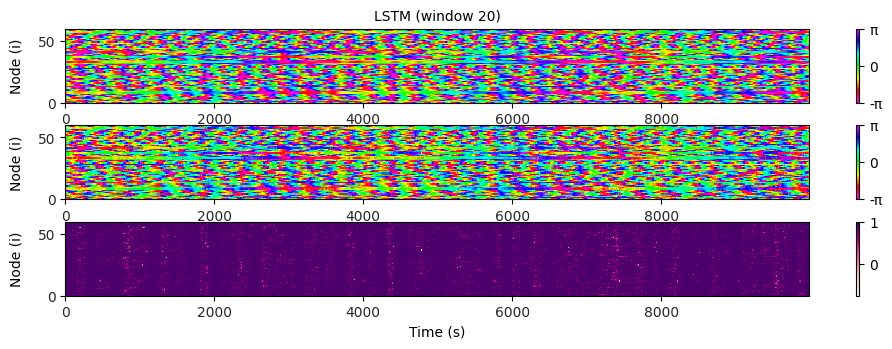

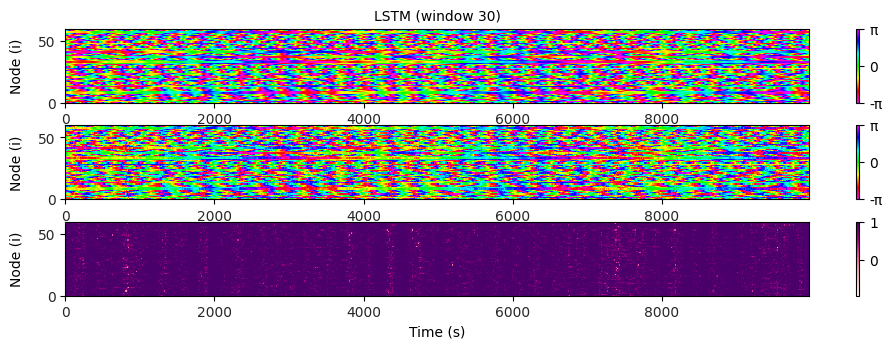

In [ ]:
for window_size in window_sizes:
    plot_results(window_size)